In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat('predict_data')

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_image', 'reference_image'])

In [4]:
train_images, reference_images = data['train_image'], data['reference_image']

In [5]:
train_images.shape, reference_images.shape

((10, 100, 100, 195), (10, 100, 100, 191))

In [6]:
def image_convert(x):
    '''
    x.shape:(p,q,m)
    (p,q)为图像大小，m为光谱维度
    '''
    (p, q, m) = x.shape
    return x.reshape(p*q, m)

**评价指标1**

Cross correlation: CC, 表征空间扭曲性，定义如下
$$
CC(\hat{X}, X) = \frac{1}{m_\lambda} \sum^{m_\lambda}_{i=1} CCS(\hat{X^i}, X^i),
$$
其中CCS是单光谱通道的**互相关性**，定义如下：
$$
CCS(A,B)=\frac{\sum^n_{i=1}(A_i-\mu_A)(B_i-\mu_B)}{\sum^n_{i=1}(A_i-\mu_A)^2(B_i-\mu_B)^2}
$$
其中 $\mu$ 代表均值

In [7]:
# 空间优良性评价函数：Cross correlation
def cc(X, Y):
    '''
    X,Y维度：p * q， p * q为单光谱维度下图像大小，m为光谱维度
    X:模型生成的图像
    Y:原始图像
    '''
    X = image_convert(X)
    Y = image_convert(Y)
    if X.shape != Y.shape:
        print('数据有误，生成图像和参考图像形状不一样')
        return
    
    m = X.shape[1]
    
    res = sum([ccs(X[:, i], Y[:, i]) for i in range(m)]) / m
    return res

def ccs(A, B):
    n = len(B)
    ave_A = np.mean(A)
    ave_B = np.mean(B)
    res = 0
    try:
        above = sum((A[i]- ave_A)*(B[i]-ave_B) for i in range(n))
        below = math.sqrt(sum((A[i]- ave_A)*(A[i]- ave_A) for i in range(n))*sum((B[i]-ave_B)*(B[i]-ave_B) for i in range(n)))
        res = above / below
    except ZeroDivisionError:
        print("分母为0， 请检查数据是否有误")
    return res

In [8]:
# 光谱连续性评价指标：Spectral angle mapper
def sam(X, Y):
    '''
    X,Y维度：n * m， n为单光谱维度下图像总像素点数目，m为光谱维度
    X:模型生成的图像
    Y:原始图像
    '''
    X = image_convert(X)
    Y = image_convert(Y)
    if X.shape != Y.shape:
        print('数据有误，生成图像和参考图像形状不一样')
        return
    
    n = X.shape[0]
    res = 0
    try:
        res = sum([sam1(X[i], Y[i]) for i in range(n)]) / n
    except ZeroDivisionError:
        print('除数为0')
    return res

def sam1(a, b):
    res = 0
    try:
        res = math.acos(np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
    except ZeroDivisionError:
        print('除数为0')
    return res

In [9]:
# 全局评价指标：Root mean squared error
def rmse(X, Y):
    X = image_convert(X)
    Y = image_convert(Y)
    
    (n, m) = X.shape
    above = math.sqrt(np.trace(np.dot(X.T, Y)))
    below = math.sqrt(n * m)
    res = 0
    try:
        res = above / below
    except ZeroDivisionError:
        print('除数为0')
    return res

In [10]:
model = tf.keras.models.load_model('./pcnn_model3.h5')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1010944   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      51232     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 191)     152991    
Total params: 1,215,167
Trainable params: 1,215,167
Non-trainable params: 0
_________________________________________________________________


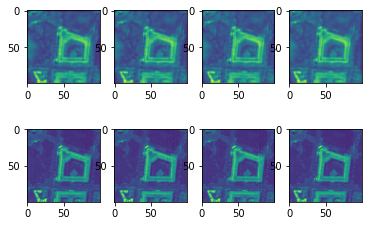

In [12]:
plt.figure()
for i in range(1,5,1):
    plt.subplot(2,4,i)
    plt.imshow(model.predict(train_images[[i]])[0,:,:,0])
    plt.subplot(2,4,i+4)
    plt.imshow(reference_images[i,:,:,0])
plt.show()

In [15]:
#禁用科学计数法
np.set_printoptions(suppress=True,   precision=10,  threshold=2000,  linewidth=150) 

In [16]:
reference_images[0]

array([[[6044., 6092., 6084., ...,   53.,   38.,   24.],
        [6012., 5932., 5936., ...,   50.,   41.,   25.],
        [4968., 5004., 5008., ...,   39.,   30.,   19.],
        ...,
        [4376., 4388., 4208., ...,   43.,   34.,   19.],
        [4364., 4272., 4284., ...,   45.,   32.,   20.],
        [4308., 4276., 4192., ...,   39.,   31.,   18.]],

       [[4984., 4820., 5000., ...,   36.,   31.,   20.],
        [4992., 4808., 4820., ...,   36.,   29.,   18.],
        [4728., 4580., 4584., ...,   31.,   23.,   16.],
        ...,
        [3986., 3866., 3716., ...,   35.,   25.,   16.],
        [4072., 4034., 3950., ...,   35.,   25.,   16.],
        [4208., 4228., 4104., ...,   41.,   28.,   19.]],

       [[4552., 4304., 4248., ...,   28.,   25.,   16.],
        [4648., 4476., 4320., ...,   28.,   21.,   15.],
        [4248., 4058., 4040., ...,   21.,   16.,   10.],
        ...,
        [4228., 4104., 4002., ...,   46.,   33.,   22.],
        [4268., 4224., 4076., ...,   39.,   3

In [18]:
output = model.predict(train_images[[0]])[0,:,:,:]
reference = reference_images[0]
xx = output / np.max(output)
yy = reference / np.max(reference)

In [22]:
cc(xx, yy)

0.642497681651177

In [20]:
sam(xx, yy)

0.1780061485010191

In [21]:
rmse(xx, yy)

0.1816238966436108